# Libs & Usefull vars

In [3]:
import numpy as np
import logging
import pickle as pkl
import pandas as pd
import pycountry
from datetime import datetime
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

# Snakemake conf file
with open('../../BoARIO-Global-Floods/workflow/config/config.yaml') as f:
    snake_cfg = yaml.safe_load(stream=f.read())

# EU regions + Swiss
EU_regs = ["AT","BE","BG","CH","DE","DK","EE","ES","FI","FR","GB","GR","HR","HU","IE","IT","LT","LU","LV","MT","NL","NO","PL","PT","RO","SE","SI","SK"]

# Event setup and generation

## MRIOT loading and setup

Creates the parameters dataframe for the sectors

In [5]:
# Load the files
df_aggreg = pd.read_excel("../../../Data/data-mriot/aggregation-files/sectors_common_aggreg_WIP.ods", sheet_name="exiobase_full_to_common_aggreg", index_col=0)
sectors_df = pd.read_csv("../../BoARIO-Sensitivity/config/exiobase3_full_sectors.csv", index_col=0, decimal=".")

# Aggregate
sectors_df.rename(df_aggreg["new sector"].to_dict(), axis=0, level=0, inplace=True)
sectors_df = sectors_df.groupby(level=0).agg({"affected":"max","rebuilding_factor":"sum","inventory_size":"max","productive_capital_to_va_ratio":"mean","inventory_tau":"max"})

# Save
sectors_df.to_parquet("../../Boario-Climada-Compound_Events/inputs/90-60_sectors_df.parquet")

# Change inventories values
sectors_df.replace(90.0,9.0,inplace=True)
sectors_df.replace(60.0,6.0,inplace=True)

# Save
sectors_df.to_parquet("../../Boario-Climada-Compound_Events/inputs/9-6_sectors_df.parquet")
sectors_df

# Change inventories values
sectors_df.replace(9.0,21.0,inplace=True)
sectors_df.replace(6.0,7.0,inplace=True)

# Save
sectors_df.to_parquet("../../Boario-Climada-Compound_Events/inputs/21-7_sectors_df.parquet")
sectors_df

/home/sjuhel/mambaforge-pypy3/envs/versa/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


,affected,rebuilding_factor,inventory_size,productive_capital_to_va_ratio,inventory_tau
Agriculture,1,0.0017,21.0,2.900000,7
Construction,1,0.5500,21.0,1.250000,7
Energy,1,0.0000,21.0,2.923077,7
Manufacture,1,0.3130,21.0,2.170690,7
Mining,1,0.0000,21.0,5.100000,7
Other,1,0.0003,inf,1.636364,7
Sales,1,0.1050,21.0,0.725000,7
Services,1,0.0300,inf,3.421429,7
Transport,1,0.0000,21.0,2.500000,7
Utilities,1,0.0000,21.0,2.238095,7


Setup MRIOT for Climada

In [4]:
with open("../../../Data/data-mriot/pkls/exiobase3/exiobase3_2011_full.pkl","rb") as f: 
    mriot = pkl.load(f)

mriot.rename_sectors(df_aggreg["new sector"].to_dict())
mriot.aggregate_duplicates()
mriot.Z.head(3)

mriot.meta.change_meta("name", "EXIOBASE3-2011")
reg = mriot.get_regions()
agg_regions = [rg if rg not in ['WA', 'WE',  'WF',  'WL',  'WM'] else "ROW" for rg in reg]
mriot = mriot.aggregate(region_agg = agg_regions)

get rebuilding sectors

In [9]:
reb_sect = sectors_df.loc[
    sectors_df.rebuilding_factor > 0, "rebuilding_factor"
].to_dict()
reb_sect

{'Agriculture and other': 0.0017,
 'Construction': 0.55,
 'Manufacture': 0.313,
 'Sales, Transports and Services': 0.1353}

In [10]:
inv_dict = sectors_df.loc[:, "inventory_size"].to_dict()
inv_dict

{'Agriculture and other': 21.0,
 'Construction': 21.0,
 'Energy and Utilities and Mining': 21.0,
 'Manufacture': 21.0,
 'Others': inf,
 'Sales, Transports and Services': inf}

load capital vector and impacts dataframe

In [11]:
k_vector = pd.read_parquet("./k_vector.parquet")
df_impact = pd.read_parquet("./input_df.parquet")

example of running a simulation

In [82]:
## SETUP

from boario.extended_models import ARIOPsiModel
from boario.event import *
from boario.simulation import Simulation

lg.setLevel(logging.WARNING)

model = ARIOPsiModel(mriot,
                     order_type = "alt",
                     alpha_base = 1.0,
                     alpha_max = 1.25,
                     alpha_tau = 365,
                     rebuild_tau = 60,
                     main_inv_dur = 90,
                     monetary_factor = 1000000,
                     temporal_units_by_step = 1,
                     iotable_year_to_temporal_unit_factor = 365,
                     infinite_inventories_sect = None,
                     inventory_dict = inv_dict,
                     productive_capital_vector = k_vector,
                     productive_capital_to_VA_dict = None,
                     psi_param=0.80,
                     inventory_restoration_tau=60
                     )

# run simulation up to one year after the last event
sim = Simulation(
            model,
            register_stocks=False,
            n_temporal_units_to_sim = df_impact.index.max()+365,
            separate_sims = False,
                 )

if True:
    events_list = [EventKapitalRebuild.from_series(
        impact=ev[1],
        rebuilding_sectors = reb_sect,
        rebuild_tau = 365,
        rebuilding_factor=1.,
        households_impact=[],
        occurrence = ev[0]+1,
        duration = 3,
        # TODO: it is assumed that exposure/impacts are expressed with full
        # values, deal with cases where CLIMADA exposure is expressed in K,
        # M or Bn
        event_monetary_factor = 1.,
    ) for ev in df_impact.iterrows()
                  ]

WARNING - 217 : Custom monetary factor found in the mrio pickle file, continuing with this one (1000000)
WARNING - 791 : Event monetary factor (1.0) differs from model monetary factor (1000000). Be careful to define your impact with the correct unit (ie in event monetary factor).
WARNING - 791 : Event monetary factor (1.0) differs from model monetary factor (1000000). Be careful to define your impact with the correct unit (ie in event monetary factor).
WARNING - 791 : Event monetary factor (1.0) differs from model monetary factor (1000000). Be careful to define your impact with the correct unit (ie in event monetary factor).
WARNING - 791 : Event monetary factor (1.0) differs from model monetary factor (1000000). Be careful to define your impact with the correct unit (ie in event monetary factor).
WARNING - 791 : Event monetary factor (1.0) differs from model monetary factor (1000000). Be careful to define your impact with the correct unit (ie in event monetary factor).
WARNING - 791 :

In [83]:
## RUNNING

sim.add_events(events_list)
sim.loop()

Processed: Step: 1939 ~ 100% Time:  0:04:03                                    
Processed: Step: 1939 ~ 100% Time:  0:04:03                                    

# Event in BoARIO

In [ ]:
import pandas as pd
import numpy as np
from boario.event import EventKapitalRecover
from boario.extended_models import ARIOPsiModel
from boario.simulation import Simulation

In [ ]:
supchain_impacted = pd.read_csv("1980_2020_wp_secs_exp_imp_shock.csv", index_col=0, header=[0,1])
dates = np.fromfile("dates.array",dtype="int")

In [ ]:
supchain_impacted

In [ ]:
dates = pd.Series(dates, name="original_dates")
boario_dates = pd.Series(dates-dates[0], name="boario_dates")
dates_df = pd.concat([dates,boario_dates],axis=1)
dates_df["boario_year"] = dates_df["boario_dates"] // 365

In [ ]:
dates_df.loc[dates_df.boario_year < 5]

In [ ]:
import pandas as pd

agg_df = pd.read_parquet("../../Boario-Climada-Compound_Events/aggregated.parquet")

In [ ]:
sim.production_realised.to_parquet("./production_realised.parquet")

In [ ]:
with open("../../../Data/data-mriot/pkls/exiobase3/exiobase3_2010_full.pkl", 'rb') as f:
    mriot = pkl.load(f)

In [ ]:
df_aggreg = pd.read_excel("../../BoARIO-Sensitivity/config/sectors_common_aggreg.ods", sheet_name="exiobase_full_to_common_aggreg", index_col=0)
mriot.rename_sectors(df_aggreg["new sector"].to_dict())
mriot.aggregate_duplicates()
mriot.Z.head(3)

mriot.meta.change_meta("name", "EXIOBASE3-2011")
reg = mriot.get_regions()
agg_regions = [rg if rg not in ['WA', 'WE',  'WF',  'WL',  'WM'] else "ROW" for rg in reg]
mriot = mriot.aggregate(region_agg = agg_regions)

INFO>196:20230615 14:19:56 - MODIFICATION -  Changed sector names
INFO>196:20230615 14:19:56 - MODIFICATION -  Reset to absolute flows
INFO>196:20230615 14:19:56 - MODIFICATION -  Reset full system to absolute flows
INFO>196:20230615 14:19:56 - MODIFICATION -  Aggregate economic core - Z
INFO>196:20230615 14:19:56 - MODIFICATION -  Aggregate economic core - Y
INFO>196:20230615 14:19:56 - MODIFICATION -  Aggregate economic core - x
INFO>196:20230615 14:19:56 - MODIFICATION -  Aggregate economic core - unit
INFO>196:20230615 14:19:56 - METADATA_CHANGE -  Changed parameter "name" from "exio382_ntnu" to "EXIOBASE3-2011"
INFO>196:20230615 14:19:56 - MODIFICATION -  Reset to absolute flows
INFO>196:20230615 14:19:56 - MODIFICATION -  Aggregate final demand y
INFO>196:20230615 14:19:56 - MODIFICATION -  Aggregate transaction matrix Z
INFO>196:20230615 14:19:56 - MODIFICATION -  Aggregate industry output x


In [ ]:
mriot.calc_all()

In [ ]:
df = pd.read_parquet("../../Boario-Climada-Compound_Events/outputs/EXIOBASE3-2010_df_impact.parquet")
df.loc[:,"TW"]

sector,"Sales, Transports and Services",Others,Manufacture,Agriculture and other,Energy and Utilities and Mining,Construction
40.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
56.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
48.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
62.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
472.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
426.0,1.172900e+09,2.442631e+08,2.220905e+09,7.189579e+07,9.735030e+07,1.524893e+08
378.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
821.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
813.0,4.238002e+08,8.825877e+07,8.024724e+08,2.597787e+07,3.517526e+07,5.509844e+07


## Looking at one Sample

In [149]:
import pandas as pd
import seaborn as sns

## Reading the files and computing indicators

agg = pd.read_parquet("../../Boario-Climada-Compound_Events/outputs/simulations/sample_0/EXIOBASE3-2010_21-7_event_separated/final_demand_unmet.parquet")
sep = pd.read_parquet("../../Boario-Climada-Compound_Events/outputs/simulations/sample_0/EXIOBASE3-2010_21-7_event_aggregated/final_demand_unmet.parquet")

def create_df_cumsum_yearly_share(df):
    """Compute cumulated impacts expressed as a share of initial value"""
    if df.loc[0].sum() == 0.:
        _df = df.cumsum()
    else:
        _df = (df-df.loc[0]).cumsum()
    return _df/(df.loc[0]*365)

def create_plot_df(agg, sep):
    """Setup dataframe for plotting"""
    agg = agg.melt(ignore_index=False).reset_index()
    sep = sep.melt(ignore_index=False).reset_index()
    agg['type'] = "agg"
    sep["type"] = "sep"
    return pd.concat([agg,sep])

agg_c = create_df_cumsum_yearly_share(agg)
sep_c = create_df_cumsum_yearly_share(sep)

plot_df = create_plot_df(agg,sep)
plot_df_c = create_plot_df(agg_c,sep_c)

In [153]:
agg.cumsum()

region                    AT                                                
sector Agriculture and other Construction Energy and Utilities and Mining   
step                                                                        
0                   0.000000     0.000000                        0.000000  \
1                   0.000000     0.000000                        0.000000   
2                   0.000092     0.000155                        0.000444   
3                   0.000197     0.000331                        0.000945   
4                   0.000317     0.006090                        0.001502   
...                      ...          ...                             ...   
7550               13.811258   922.909274                       46.953139   
7551               13.811258   922.909274                       46.953139   
7552               13.811258   922.909274                       46.953139   
7553               13.811258   922.909274                       46.953139   
7554               13.811258   922.909274                       46.953139   

region                                                        
sector Manufacture    Others Sales, Transports and Services   
step                                                          
0         0.000000  0.000000                       0.000000  \
1         0.000000  0.000000                       0.000000   
2         0.000709  0.000077                       0.002290   
3         0.001518  0.000155                       0.004579   
4         0.009002  0.000232                       0.008994   
...            ...       ...                            ...   
7550    839.510613  3.386138                     175.135370   
7551    839.510613  3.386138                     175.135370   
7552    839.510613  3.386138                     175.135370   
7553    839.510613  3.386138                     175.135370   
7554    839.510613  3.386138                     175.135370   

region                    AU                                                
sector Agriculture and other Construction Energy and Utilities and Mining   
step                                                                        
0                   0.000000     0.000000                        0.000000  \
1                   0.000000     0.000000                        0.000000   
2                   0.000219     0.000131                        0.006776   
3                   0.000473     0.000282                        0.014264   
4                   0.000845     0.002768                        0.022429   
...                      ...          ...                             ...   
7550              126.454305   615.783675                      758.227681   
7551              126.454305   615.783675                      758.227681   
7552              126.454305   615.783675                      758.227681   
7553              126.454305   615.783675                      758.227681   
7554              126.454305   615.783675                      758.227681   

region               ...                              US                  
sector  Manufacture  ... Energy and Utilities and Mining    Manufacture   
step                 ...                                                  
0          0.000000  ...                        0.000000       0.000000  \
1          0.000000  ...                        0.000000       0.000000   
2          0.004177  ...                        0.036775       0.027140   
3          0.008761  ...                        0.076817       0.057417   
4          0.036629  ...                        0.119928       0.356115   
...             ...  ...                             ...            ...   
7550    1922.245150  ...                    15044.194184  232475.091233   
7551    1922.245150  ...                    15044.194184  232475.091233   
7552    1922.245150  ...                    15044.194184  232475.091233   
7553    1922.245150  ...                    15044.194184  2

In [ ]:
plot_df_noabs = plot_df.groupby(["region","type","step"],as_index=False)["value"].sum().copy()
plot_df_noabs['value'] = plot_df_noabs['value']/(6)
#plot_df_noabs['region'] = "global"
#plot_df_noabs = plot_df.copy()

graph = sns.relplot(
    data=plot_df_noabs,#.loc[plot_df_noabs.step<400],
    x="step",
    y="value",
    col="region",
    hue="type",
    kind="line",
    col_wrap=3,
    facet_kws={"sharey":False},
)

#graph.set_axis_labels("","% of direct losses")
#graph.set_xlabel("")
#graph.set_titles("{col_name}")
#graph.fig.subplots_adjust(top=0.1) # adjust the Figure in rp
#graph.fig.suptitle("Indirect production change two years after the shock",y=1.05)
#set_title()
#graph.despine(left=True, bottom=True)
#ax.tick_params(bottom=False)
#ax2.tick_params(bottom=False)

<Axes: xlabel='step'>

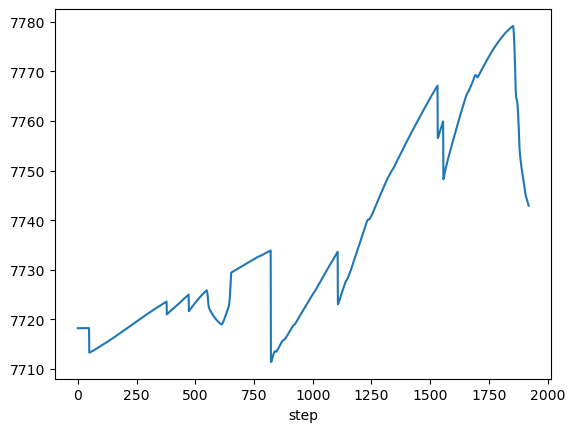

Compute relative difference

In [ ]:
agg_reldiff=((agg.loc[:,region] - agg.loc[0,region])/agg.loc[0,region])
sep_reldiff=((sep.loc[:,region] - sep.loc[0,region])/sep.loc[0,region])

In [ ]:
(agg_reldiff-sep_reldiff).plot(figsize=(20,20))

<Axes: xlabel='step'>

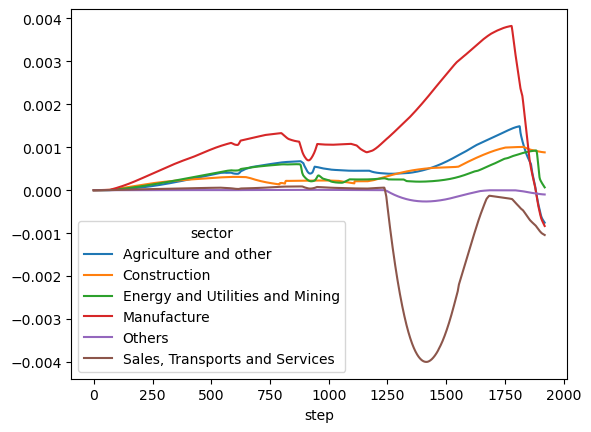

In [73]:
sep_reldiff.plot()

<Axes: xlabel='step'>

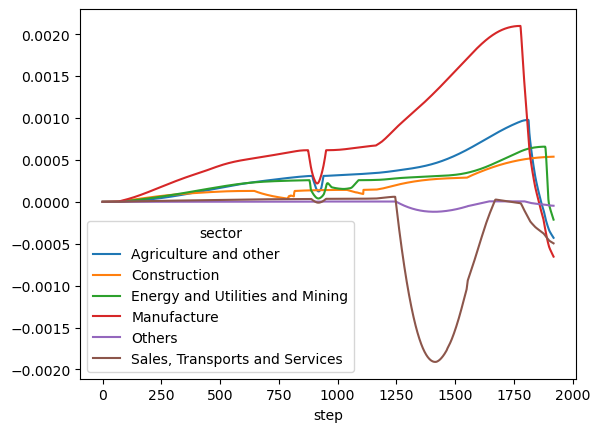

In [74]:
agg_reldiff.plot()

# All sample results

In [5]:
# Load direct impacts dataframe
df = pd.read_parquet("./")

In [7]:
df
# If you want to look at the regions affected by each event
#df.apply(lambda row:row[row>0].index.get_level_values(0).unique().to_list(), axis=1)

region                             AT                     \
sector Sales, Transports and Services Others Manufacture   
40.0                              0.0    0.0         0.0   
56.0                              0.0    0.0         0.0   
48.0                              0.0    0.0         0.0   
62.0                              0.0    0.0         0.0   
0.0                               0.0    0.0         0.0   
472.0                             0.0    0.0         0.0   
426.0                             0.0    0.0         0.0   
378.0                             0.0    0.0         0.0   
821.0                             0.0    0.0         0.0   
813.0                             0.0    0.0         0.0   
815.0                             0.0    0.0         0.0   
787.0                             0.0    0.0         0.0   
1185.0                            0.0    0.0         0.0   
1162.0                            0.0    0.0         0.0   
1106.0                            0.0    0.0         0.0   
1462.0                            0.0    0.0         0.0   
1555.0                            0.0    0.0         0.0   
1544.0                            0.0    0.0         0.0   
1531.0                            0.0    0.0         0.0   
34.0                              0.0    0.0         0.0   
87.0                              0.0    0.0         0.0   
66.0                              0.0    0.0         0.0   
416.0                             0.0    0.0         0.0   
811.0                             0.0    0.0         0.0   
800.0                             0.0    0.0         0.0   
794.0                             0.0    0.0         0.0   
1077.0                            0.0    0.0         0.0   
1159.0                            0.0    0.0         0.0   
1518.0                            0.0    0.0         0.0   
1548.0                            0.0    0.0         0.0   

region                                                                     \
sector Agriculture and other Energy and Utilities and Mining Construction   
40.0                     0.0                             0.0          0.0   
56.0                     0.0                             0.0          0.0   
48.0                     0.0                             0.0          0.0   
62.0                     0.0                             0.0          0.0   
0.0                      0.0                             0.0          0.0   
472.0                    0.0                             0.0          0.0   
426.0                    0.0                             0.0          0.0   
378.0                    0.0                             0.0          0.0   
821.0                    0.0                             0.0          0.0   
813.0                    0.0                             0.0          0.0   
815.0                    0.0                             0.0          0.0   
787.0                    0.0                             0.0          0.0   
1185.0                   0.0                             0.0          0.0   
1162.0                   0.0                             0.0          0.0   
1106.0                   0.0                             0.0          0.0   
1462.0                   0.0                             0.0          0.0   
1555.0                   0.0                             0.0          0.0   
1544.0                   0.0                             0.0          0.0   
1531.0                   0.0                             0.0          0.0   
34.0                     0.0                             0.0          0.0   
87.0                     0.0                             0.0          0.0   
66.0                     0.0                             0.0          0.0   
416.0                    0.0                             0.0          0.0   
811.0                    0.0                             0.0          0.0   
800.0                    0.0                             0.0          0.0   


In [12]:
def get_affected_regions(group):
    affected_regions = group.loc[group["total direct impact"] > 0, ["region", "total direct impact"]]
    sorted_regions = affected_regions.sort_values(by="total direct impact", ascending=False)["region"].unique()
    return pd.Series({"affected regions": sorted_regions})

res_df = pd.read_parquet("../../Boario-Climada-Compound_Events/outputs/results_meta_df.parquet")
res_df = res_df.reset_index()
res_df.loc[(res_df["variable"]=="production_realised"),"total indirect impact"] = res_df.loc[(res_df["variable"]=="production_realised"),"total indirect impact"]*-1

res_df["sample total direct damage"] = res_df.groupby(["sample","MRIOT","invtype","simtype","variable"])["total direct impact"].transform("sum")
affected_regions_df = res_df.groupby(["sample", "MRIOT", "invtype", "simtype", "variable"]).apply(get_affected_regions)
res_df = res_df.groupby(["sample","MRIOT","invtype","simtype","variable", "region"]).sum(numeric_only=True).reset_index()
res_df = res_df.merge(affected_regions_df, left_on=["sample", "MRIOT", "invtype", "simtype", "variable"], right_index=True)


# List of regions
EU_regs = ["AT","BE","BG","CH","DE","DK","EE","ES","FI","FR","GB","GR","HR","HU","IE","IT","LT","LU","LV","MT","NL","NO","PL","PT","RO","SE","SI","SK"]

# custom aggregation to handle the affected regions
grouped = res_df.loc[res_df.region.isin(EU_regs)].groupby(["sample", "MRIOT", "invtype", "simtype", "variable"]).agg({
    "region": lambda x: "Europe",  # Set region to "Europe"
    "total direct impact": "sum",   # Sum total direct impact
    "total indirect impact": "sum",  # Sum total indirect impact
    "sample total direct damage": "first",  # Sum sample total direct damage
    "affected regions": "first"  # Use the first value of affected regions
}).reset_index()

# Display the updated DataFrame
res_df = pd.concat([res_df, grouped], ignore_index=True)


# sample : sample id
# MRIOT : MRIOT used for simulation
# invtype : type of inventory "scenario" use (example: 90-60 is 90 days stocks, 60 days gap replenishment)
# simtype : aggregated is all events taken together, separated is all events isolated then summed
# variable : variables looked at (e.g. production realised shows the cumulated difference between actual production during the simulation and initial production)
# region : is the region looked at
# total direct impact : total direct impact (in the region)
# total indirect impact : total indirect impact (in the region) (the value of "variable")
# sample total direct damage : total direct impact for the whole sample
# affected regions : all regions affected by at least one event sorted by direct impact.
# number of events : WIP
res_df

,sample,MRIOT,invtype,simtype,variable,region,total direct impact,total indirect impact,sample total direct damage,affected regions
0,0,EXIOBASE3-2010,9-6,aggregated,final_demand_unmet,AT,0.0,291.553769,1.361949e+12,"[US, JP, ROW, CN, TW, GB, IE, KR, CA, MX]"
1,0,EXIOBASE3-2010,9-6,aggregated,final_demand_unmet,AU,0.0,601.966771,1.361949e+12,"[US, JP, ROW, CN, TW, GB, IE, KR, CA, MX]"
2,0,EXIOBASE3-2010,9-6,aggregated,final_demand_unmet,BE,0.0,1112.570652,1.361949e+12,"[US, JP, ROW, CN, TW, GB, IE, KR, CA, MX]"
3,0,EXIOBASE3-2010,9-6,aggregated,final_demand_unmet,BG,0.0,48.986341,1.361949e+12,"[US, JP, ROW, CN, TW, GB, IE, KR, CA, MX]"
4,0,EXIOBASE3-2010,9-6,aggregated,final_demand_unmet,BR,0.0,855.987248,1.361949e+12,"[US, JP, ROW, CN, TW, GB, IE, KR, CA, MX]"
...,...,...,...,...,...,...,...,...,...,...
110395,99,EXIOBASE3-2010,90-60,separated,intermediate_demand,Europe,0.0,38175.155303,6.901143e+11,"[US, JP, ROW, CN, KR, TW, MX, CA]"
110396,99,EXIOBASE3-2010,90-60,separated,limiting_inputs,Europe,0.0,0.000000,6.901143e+11,"[US, JP, ROW, CN, KR, TW, MX, CA]"
110397,99,EXIOBASE3-2010,90-60,separated,overproduction,Europe,0.0,504.157001,6.901143e+11,"[US, JP, ROW, CN, KR, TW, MX, CA]"
110398,99,EXIOBASE3-2010,90-60,separated,production_realised,Europe,0.0,13249.003035,6.901143e+11,"[US, JP, ROW, CN, KR, TW, MX, CA]"


<Figure size 640x480 with 0 Axes>

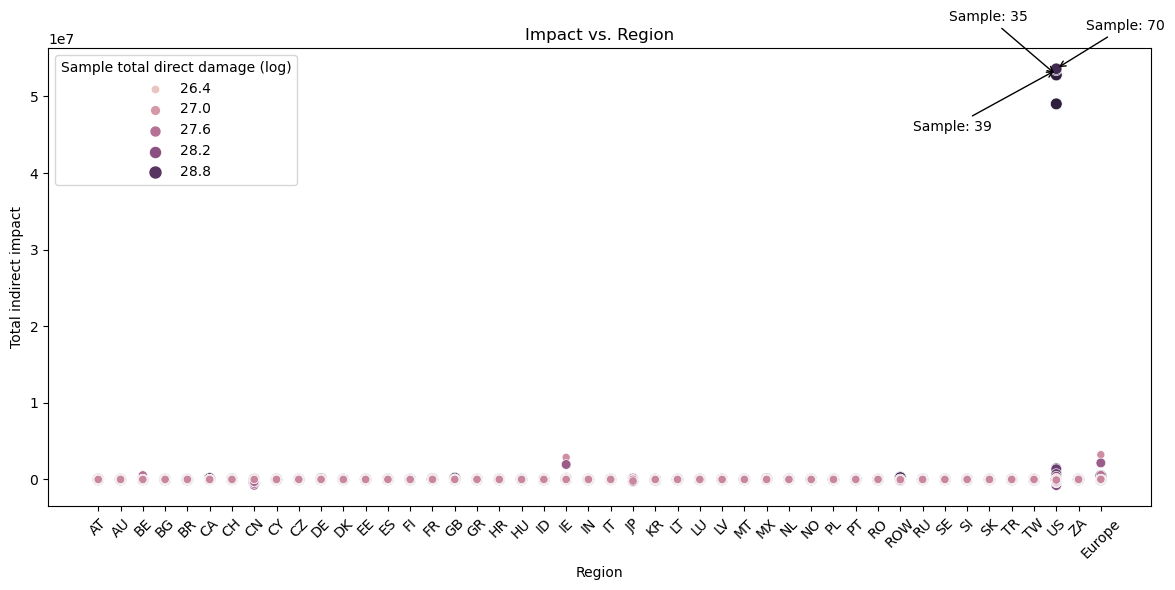

In [41]:
plt.clf()
plt.figure(figsize=(12, 6))

plot_df = res_df.loc[(res_df.variable=="production_realised") & (res_df.invtype=="9-6")].copy()
plot_df["size"] = plot_df["sample total direct damage"].apply(lambda x: max(1, x))  # Avoid log(0)
plot_df["size"] = plot_df["size"].apply(lambda x: np.log(x))

ax = sns.scatterplot(data=plot_df, x="region", y="total indirect impact", size="size", hue="size")
plt.xticks(rotation=45)
plt.xlabel("Region")
plt.ylabel("Total indirect impact")
plt.title("Impact vs. Region")
plt.legend(title="Sample total direct damage (log)")

# Annotate extreme y-axis values with the 'sample' attribute
extreme_values = plot_df.nlargest(3, "total indirect impact")
for index, row in extreme_values.iterrows():
    jitter_x = np.random.randint(-80, 80)  # Random jitter in x-coordinate
    jitter_y = np.random.randint(-50, 50)  # Random jitter in y-coordinate
    ax.annotate(f"Sample: {row['sample']}", (row['region'], row['total indirect impact']), textcoords="offset points", xytext=(jitter_x,jitter_y), ha='center',
                       arrowprops=dict(arrowstyle="->")  # Add an arrow
               )

plt.tight_layout()
plt.show()

In [31]:
plot_df

,sample,MRIOT,invtype,simtype,variable,region,total direct impact,total indirect impact,sample total direct damage,affected regions,size
180,0,EXIOBASE3-2010,9-6,aggregated,production_realised,AT,0.000000e+00,51.358803,1.361949e+12,"[US, JP, ROW, CN, TW, GB, IE, KR, CA, MX]",27.939938
181,0,EXIOBASE3-2010,9-6,aggregated,production_realised,AU,0.000000e+00,-286.523857,1.361949e+12,"[US, JP, ROW, CN, TW, GB, IE, KR, CA, MX]",27.939938
182,0,EXIOBASE3-2010,9-6,aggregated,production_realised,BE,0.000000e+00,310.614377,1.361949e+12,"[US, JP, ROW, CN, TW, GB, IE, KR, CA, MX]",27.939938
183,0,EXIOBASE3-2010,9-6,aggregated,production_realised,BG,0.000000e+00,-4.965592,1.361949e+12,"[US, JP, ROW, CN, TW, GB, IE, KR, CA, MX]",27.939938
184,0,EXIOBASE3-2010,9-6,aggregated,production_realised,BR,0.000000e+00,-117.522424,1.361949e+12,"[US, JP, ROW, CN, TW, GB, IE, KR, CA, MX]",27.939938
...,...,...,...,...,...,...,...,...,...,...,...
110338,97,EXIOBASE3-2010,9-6,separated,production_realised,Europe,1.972328e+08,24499.990816,1.219387e+12,"[CN, JP, US, ROW, KR, TW, MX, FR, NL, CA, RU]",27.829370
110356,98,EXIOBASE3-2010,9-6,aggregated,production_realised,Europe,0.000000e+00,-1432.684857,5.512604e+11,"[JP, ROW, US, TW, CN, MX, KR, RU]",27.035473
110362,98,EXIOBASE3-2010,9-6,separated,production_realised,Europe,0.000000e+00,23337.500974,5.512604e+11,"[JP, ROW, US, TW, CN, MX, KR, RU]",27.035473
110380,99,EXIOBASE3-2010,9-6,aggregated,production_realised,Europe,0.000000e+00,-2130.068421,6.901143e+11,"[US, JP, ROW, CN, KR, TW, MX, CA]",27.260123


<Figure size 640x480 with 0 Axes>

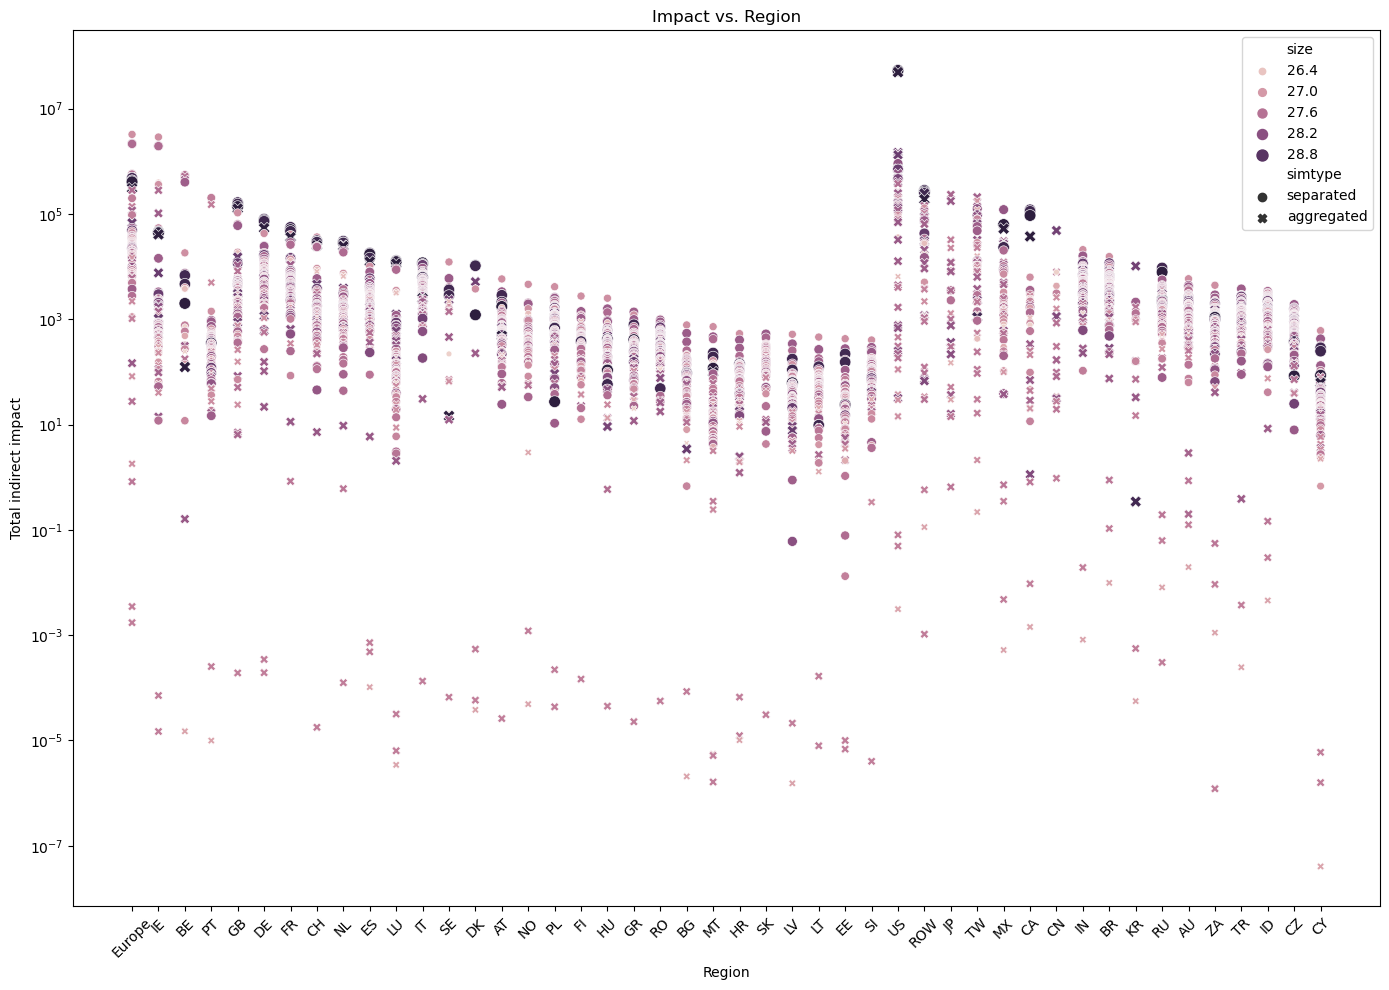

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
plt.figure(figsize=(14, 10))


plot_df = res_df.loc[(res_df.variable == "production_realised") & (res_df.invtype == "9-6")].copy()
plot_df["size"] = plot_df["sample total direct damage"].apply(lambda x: max(1, x))  # Avoid log(0)
plot_df["size"] = plot_df["size"].apply(lambda x: np.log(x))
# Filter plot_df to include only regions from EU_regs
plot_df_europe = plot_df[(plot_df["region"].isin(EU_regs)) | (plot_df["region"]=="Europe")].sort_values("total indirect impact", ascending=False)
plot_df = plot_df.loc[(~res_df.region.isin(EU_regs)) & (plot_df["region"]!="Europe")].sort_values("total indirect impact", ascending=False)

# Calculate the position for the "Europe" label
europe_x_pos = 14
europe_y_pos = 0.5*10**9

sns.scatterplot(data=plot_df_europe, x="region", y="total indirect impact", size="size", hue="size", style="simtype", legend=False)
sns.scatterplot(data=plot_df, x="region", y="total indirect impact", size="size", hue="size", style="simtype")


# Annotate "Europe" label with a bracket
#lt.annotate("Europe", xy=(europe_x_pos, europe_y_pos), xytext=(europe_x_pos, europe_y_pos + 1*10**8), ha="center", fontsize=12)

plt.xticks(rotation=45)
plt.xlabel("Region")
plt.ylabel("Total indirect impact")
plt.title("Impact vs. Region")
plt.yscale("log")
plt.legend(title="")
plt.tight_layout()
plt.show()


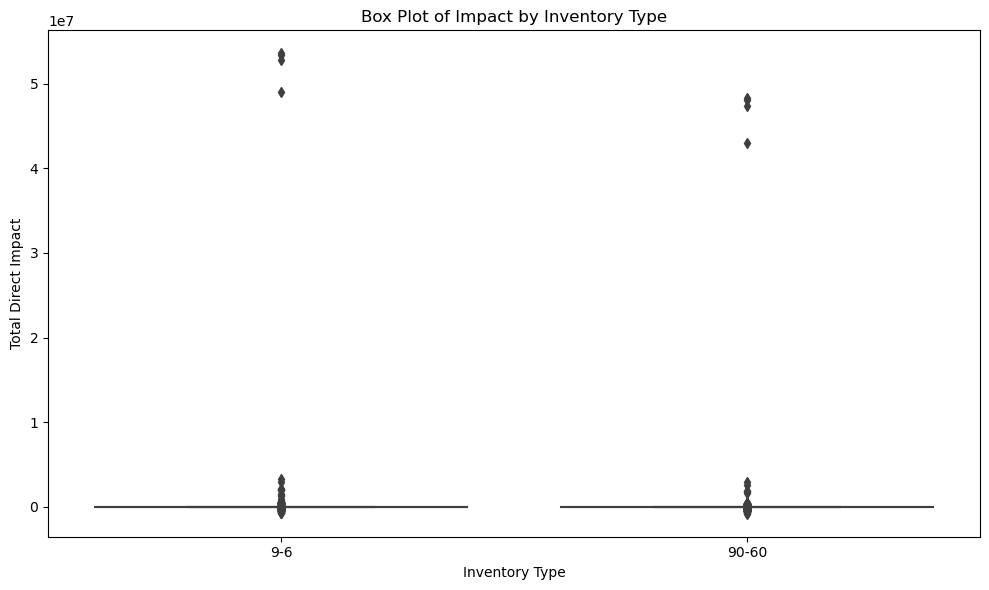

In [45]:
plt.figure(figsize=(10, 6))

plot_df = res_df.loc[(res_df.variable=="production_realised")].copy()
sns.boxplot(data=plot_df, x="invtype", y="total indirect impact")
plt.xlabel("Inventory Type")
plt.ylabel("Total Direct Impact")
plt.title("Box Plot of Impact by Inventory Type")
plt.tight_layout()
plt.show()

In [1]:
plot_df = res_df.loc[(res_df.variable=="production_realised")].copy()

impact_columns = ["total direct impact", "total indirect impact", "sample total direct damage"]
impact_corr = plot_df[impact_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(impact_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Impact Columns")
plt.show()

NameError: name 'res_df' is not defined

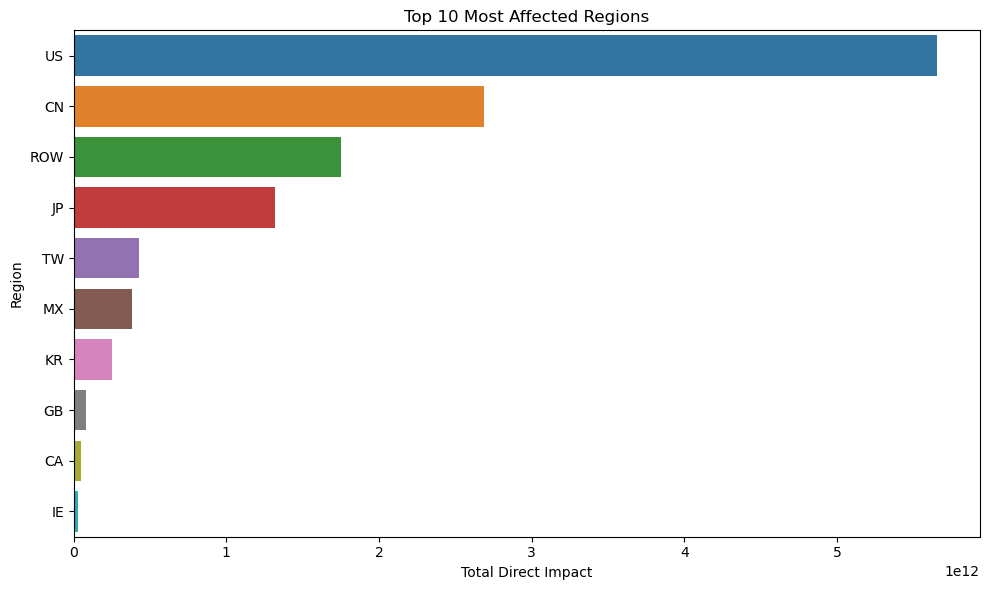

In [100]:
most_affected_regions = res_df.groupby("region")["total direct impact"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=most_affected_regions.values, y=most_affected_regions.index)
plt.xlabel("Total Direct Impact")
plt.ylabel("Region")
plt.title("Top 10 Most Affected Regions")
plt.tight_layout()
plt.show()

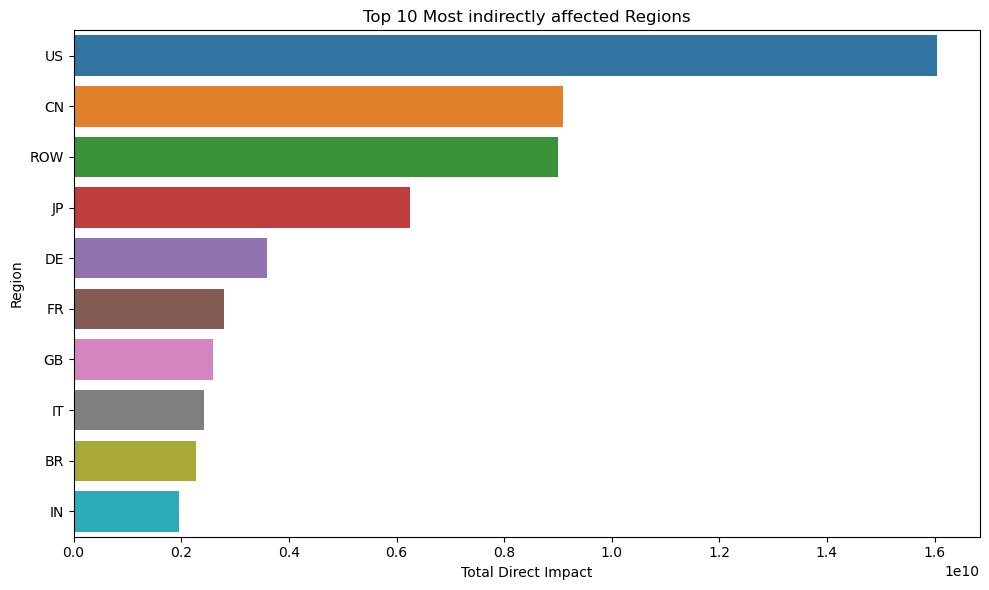

In [101]:
plot_df = res_df.loc[(res_df.variable=="production_realised")].copy()

most_affected_regions = (res_df.groupby("region")["total indirect impact"].sum()).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=most_affected_regions.values, y=most_affected_regions.index)
plt.xlabel("Total Direct Impact")
plt.ylabel("Region")
plt.title("Top 10 Most indirectly affected Regions")
plt.tight_layout()
plt.show()

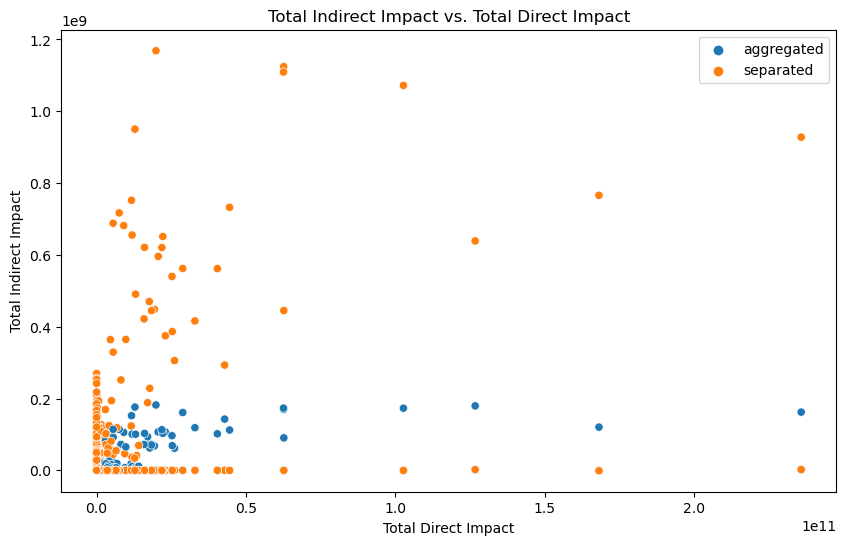

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = res_df.loc[(res_df.variable=="production_realised")].copy()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x="total direct impact", y="total indirect impact", hue="simtype")
plt.xlabel("Total Direct Impact")
plt.ylabel("Total Indirect Impact")
plt.title("Total Indirect Impact vs. Total Direct Impact")
plt.legend()
plt.show()

In [108]:
res_df[res_df["total indirect impact"]>0]

,sample,MRIOT,invtype,simtype,variable,region,total direct impact,total indirect impact,sample total direct damage,affected regions
0,0,EXIOBASE3-2010,9-6,aggregated,final_demand_unmet,AT,0.0,2.537007e+06,1.284574e+12,"[US, CN, ROW, TW, MX, JP, CA, KR, NL, RU]"
1,0,EXIOBASE3-2010,9-6,aggregated,final_demand_unmet,AU,0.0,8.118281e+06,1.284574e+12,"[US, CN, ROW, TW, MX, JP, CA, KR, NL, RU]"
2,0,EXIOBASE3-2010,9-6,aggregated,final_demand_unmet,BE,0.0,3.230631e+06,1.284574e+12,"[US, CN, ROW, TW, MX, JP, CA, KR, NL, RU]"
3,0,EXIOBASE3-2010,9-6,aggregated,final_demand_unmet,BG,0.0,3.532751e+05,1.284574e+12,"[US, CN, ROW, TW, MX, JP, CA, KR, NL, RU]"
4,0,EXIOBASE3-2010,9-6,aggregated,final_demand_unmet,BR,0.0,1.471942e+07,1.284574e+12,"[US, CN, ROW, TW, MX, JP, CA, KR, NL, RU]"
...,...,...,...,...,...,...,...,...,...,...
3588,9,EXIOBASE3-2010,90-60,separated,production_realised,PL,0.0,4.212984e+02,6.745074e+11,"[ROW, CN, JP, US, TW, MX, KR, CA]"
3589,9,EXIOBASE3-2010,90-60,separated,production_realised,PT,0.0,2.923738e+01,6.745074e+11,"[ROW, CN, JP, US, TW, MX, KR, CA]"
3590,9,EXIOBASE3-2010,90-60,separated,production_realised,RO,0.0,1.696311e+02,6.745074e+11,"[ROW, CN, JP, US, TW, MX, KR, CA]"
3594,9,EXIOBASE3-2010,90-60,separated,production_realised,SI,0.0,1.661179e+01,6.745074e+11,"[ROW, CN, JP, US, TW, MX, KR, CA]"


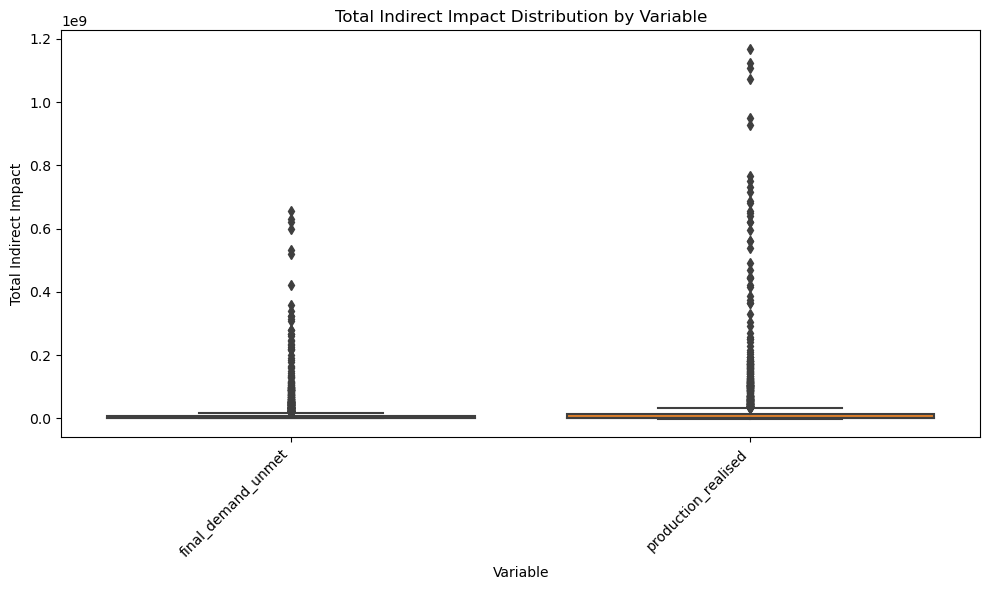

In [103]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=res_df, x="variable", y="total indirect impact")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Variable")
plt.ylabel("Total Indirect Impact")
plt.title("Total Indirect Impact Distribution by Variable")
plt.tight_layout()
plt.show()


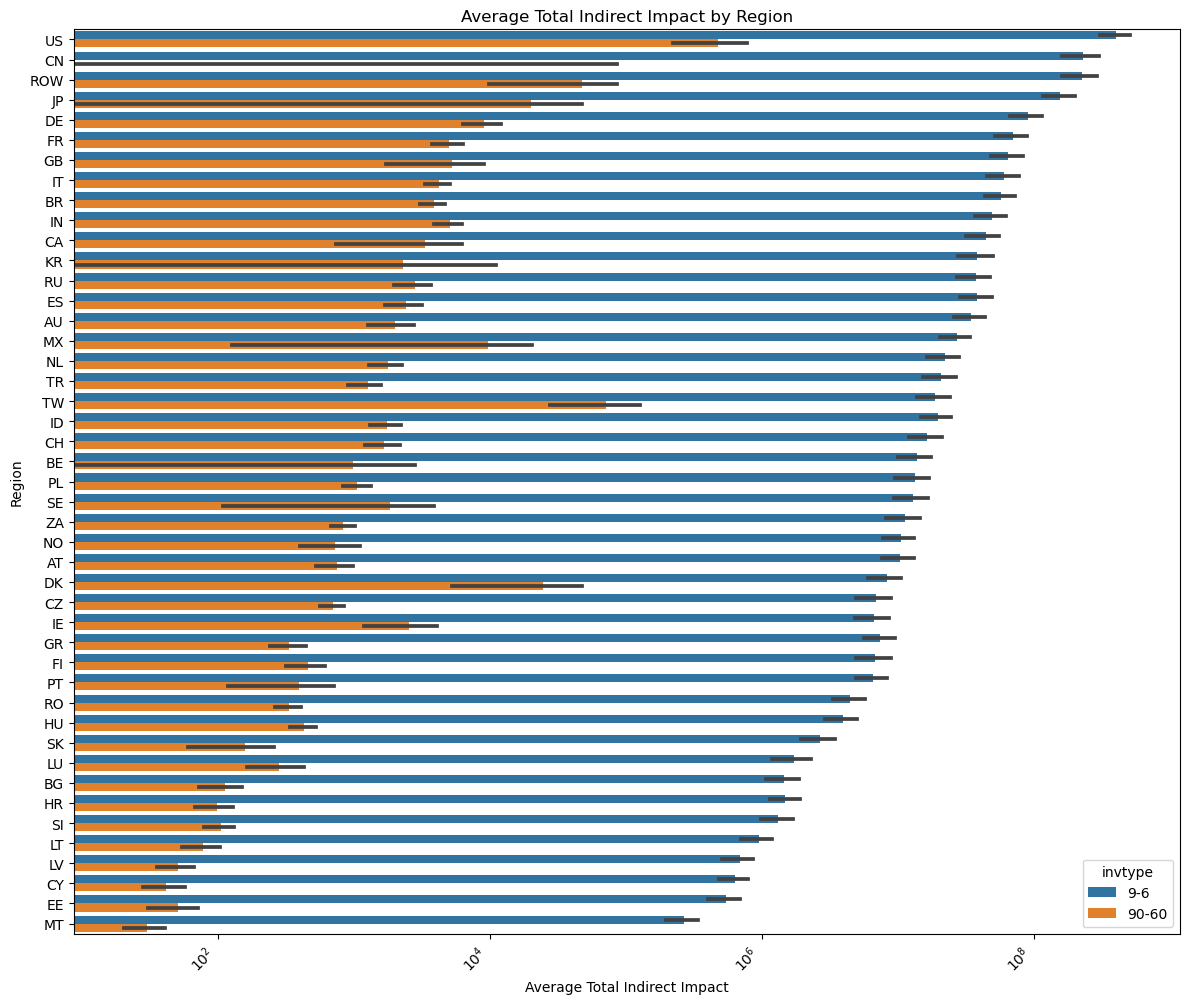

In [115]:
plt.figure(figsize=(12, 10))
plot_df=res_df.sort_values(by="total indirect impact", ascending=False).copy()
sns.barplot(data=plot_df, y="region", x="total indirect impact", hue="invtype")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Region")
plt.xlabel("Average Total Indirect Impact")
plt.title("Average Total Indirect Impact by Region")
plt.tight_layout()
plt.xscale("log")  # Set Y-axis to log scale
plt.show()

<Figure size 1200x1000 with 0 Axes>

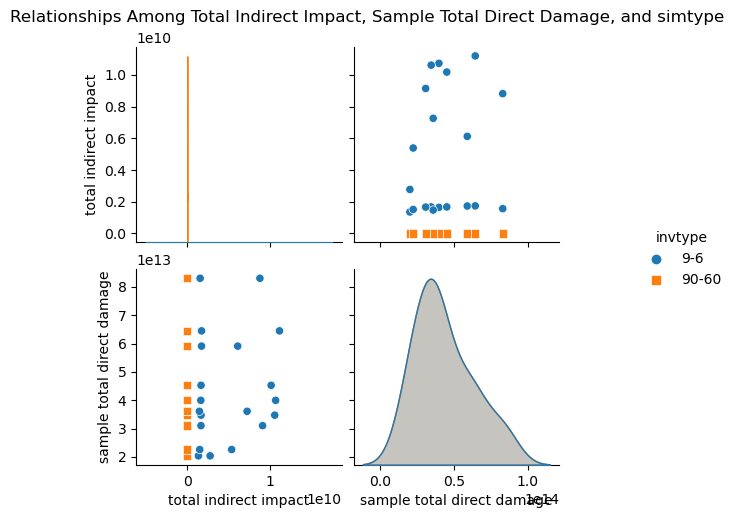

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset the DataFrame to include only relevant columns
plot_df = res_df.groupby(["sample","MRIOT","simtype","invtype","variable"])[["total indirect impact", "sample total direct damage"]].sum().copy().reset_index()
plot_df = plot_df.loc[(plot_df["variable"]=="production_realised")]
#subset_df = res_df[["total indirect impact", "sample total direct damage", "invtype", "simtype"]]
plt.figure(figsize=(12, 10))

# Create a pair plot
sns.pairplot(plot_df[["total indirect impact", "sample total direct damage", "invtype", "simtype"]], hue="invtype", markers=["o", "s"], diag_kind="kde")
plt.suptitle("Relationships Among Total Indirect Impact, Sample Total Direct Damage, and simtype", y=1.02)
#plt.tight_layout()
plt.show()


<Figure size 1200x1000 with 0 Axes>

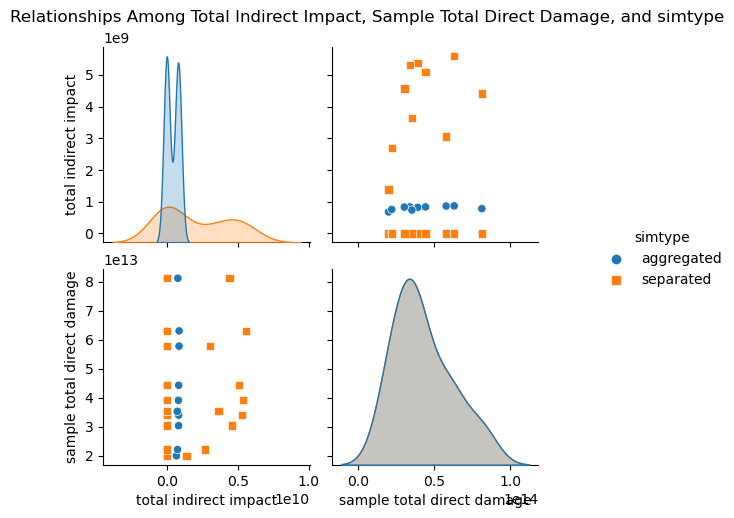

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset the DataFrame to include only relevant columns
plot_df = res_df.groupby(["sample","MRIOT","simtype","invtype","variable"])[["total indirect impact", "sample total direct damage"]].sum().copy().reset_index()
plot_df = plot_df.loc[plot_df["variable"]=="production_realised"]
#subset_df = res_df[["total indirect impact", "sample total direct damage", "invtype", "simtype"]]
plt.figure(figsize=(12, 10))

# Create a pair plot
sns.pairplot(plot_df[["total indirect impact", "sample total direct damage", "invtype", "simtype"]], hue="simtype", markers=["o", "s"], diag_kind="kde")
plt.suptitle("Relationships Among Total Indirect Impact, Sample Total Direct Damage, and simtype", y=1.02)
#plt.tight_layout()
plt.show()


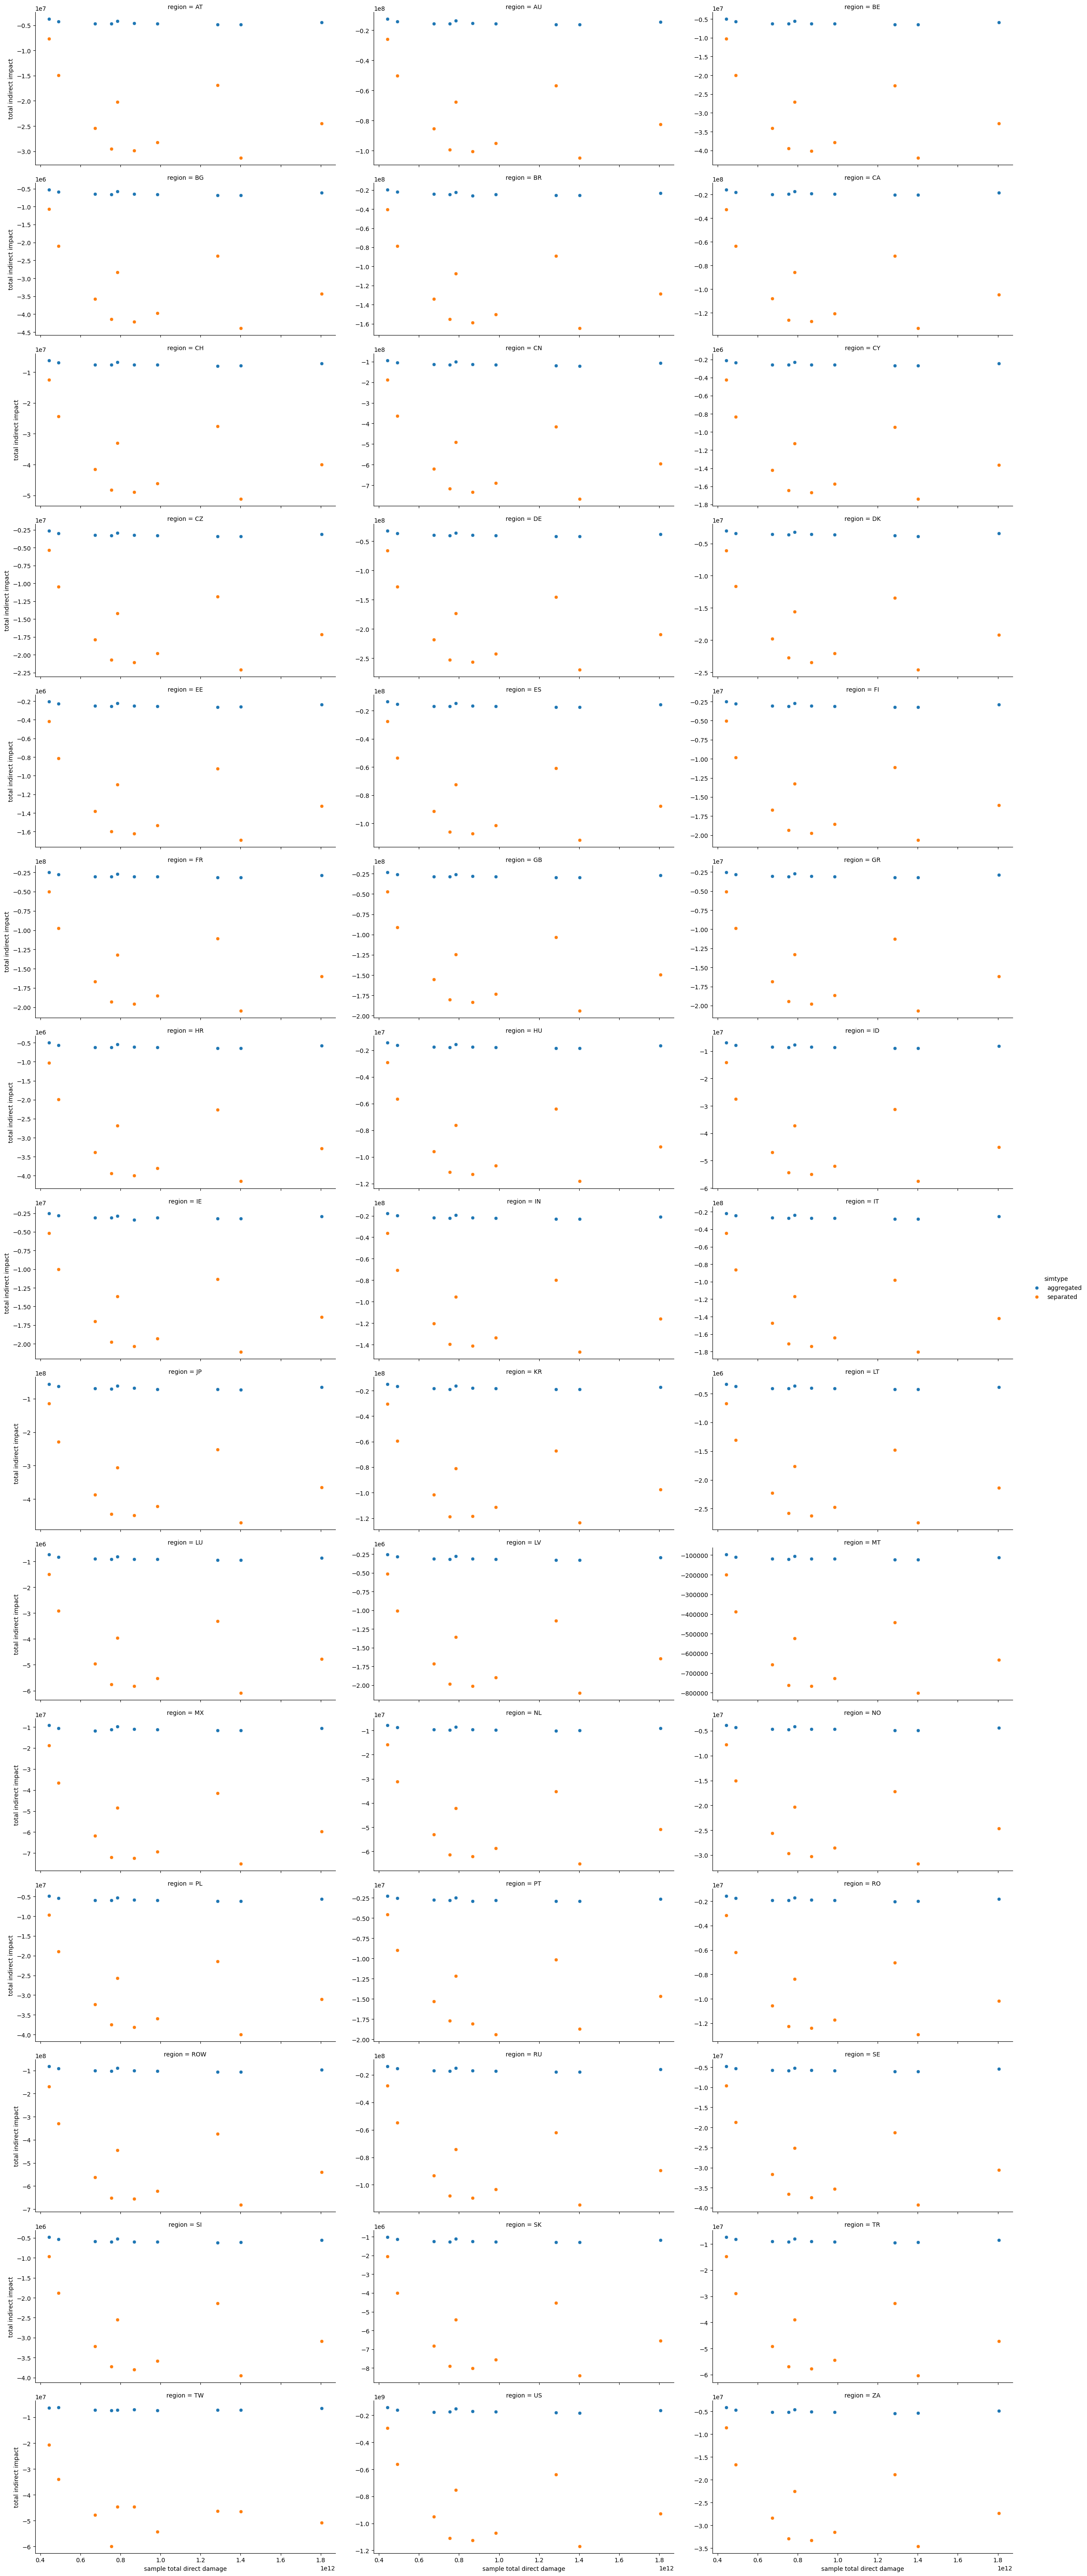

In [24]:
# Set up the grid layout
g = sns.FacetGrid(res_df, col="region", hue="simtype", col_wrap=3, height=4, aspect=2, sharey=False)

# Plot scatter plots
g.map_dataframe(sns.scatterplot,
                y="total indirect impact",
                x="sample total direct damage")

# Add legend
g.add_legend()

# Adjust layout
g.tight_layout()

# Show the plot
plt.show()

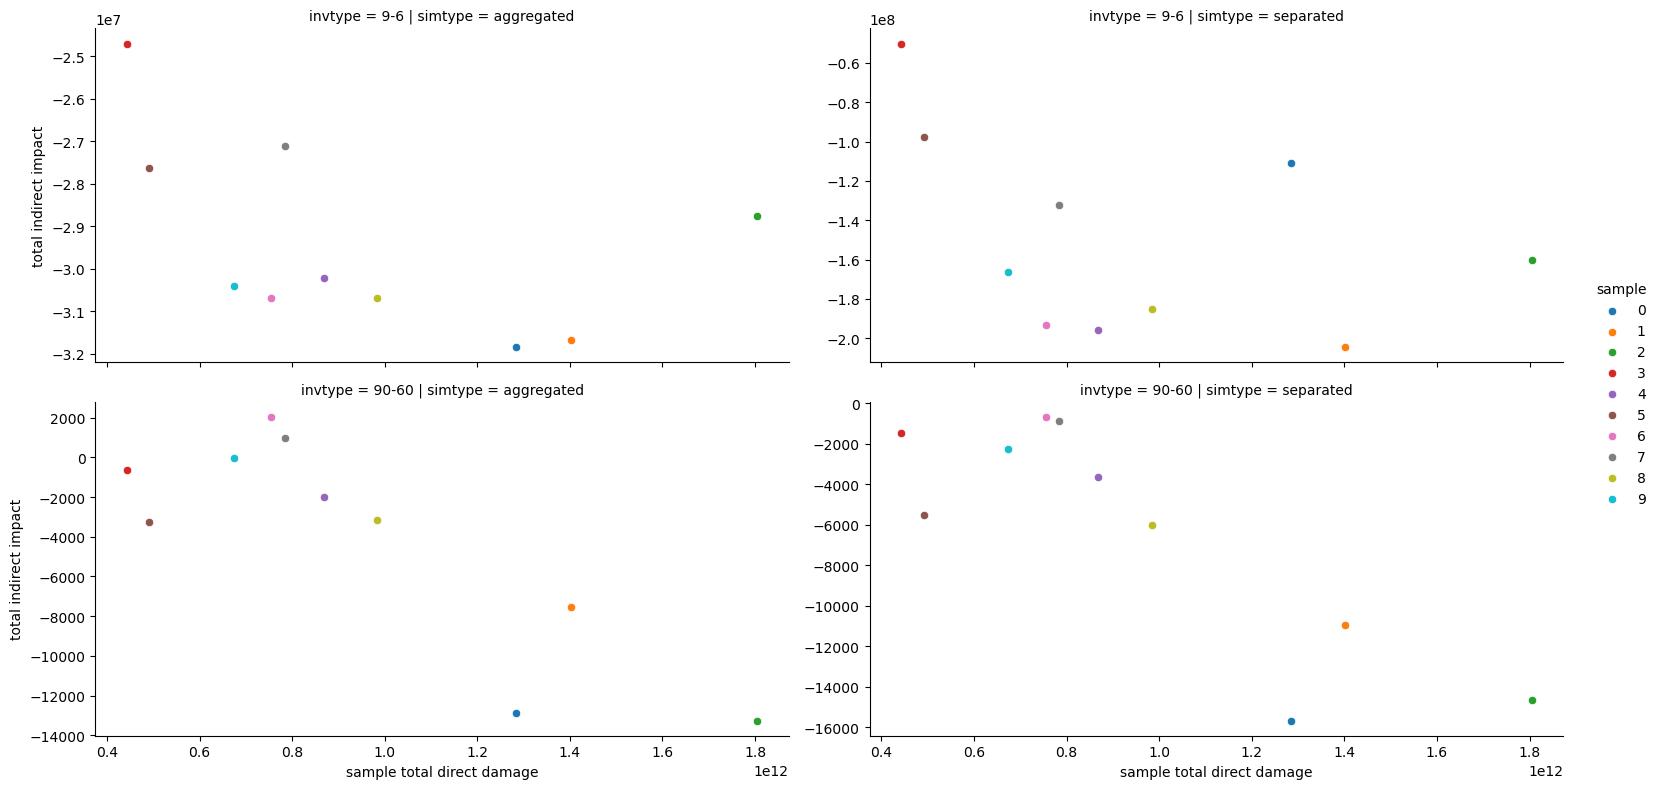

In [4]:
# Set up the grid layout
g = sns.FacetGrid(res_df, col="simtype", hue="sample", row="invtype", height=4, aspect=2, sharey=False)

# Plot scatter plots
g.map_dataframe(sns.scatterplot,
                y="total indirect impact",
                x="sample total direct damage")

# Add legend
g.add_legend()

# Adjust layout
g.tight_layout()

# Show the plot
plt.show()

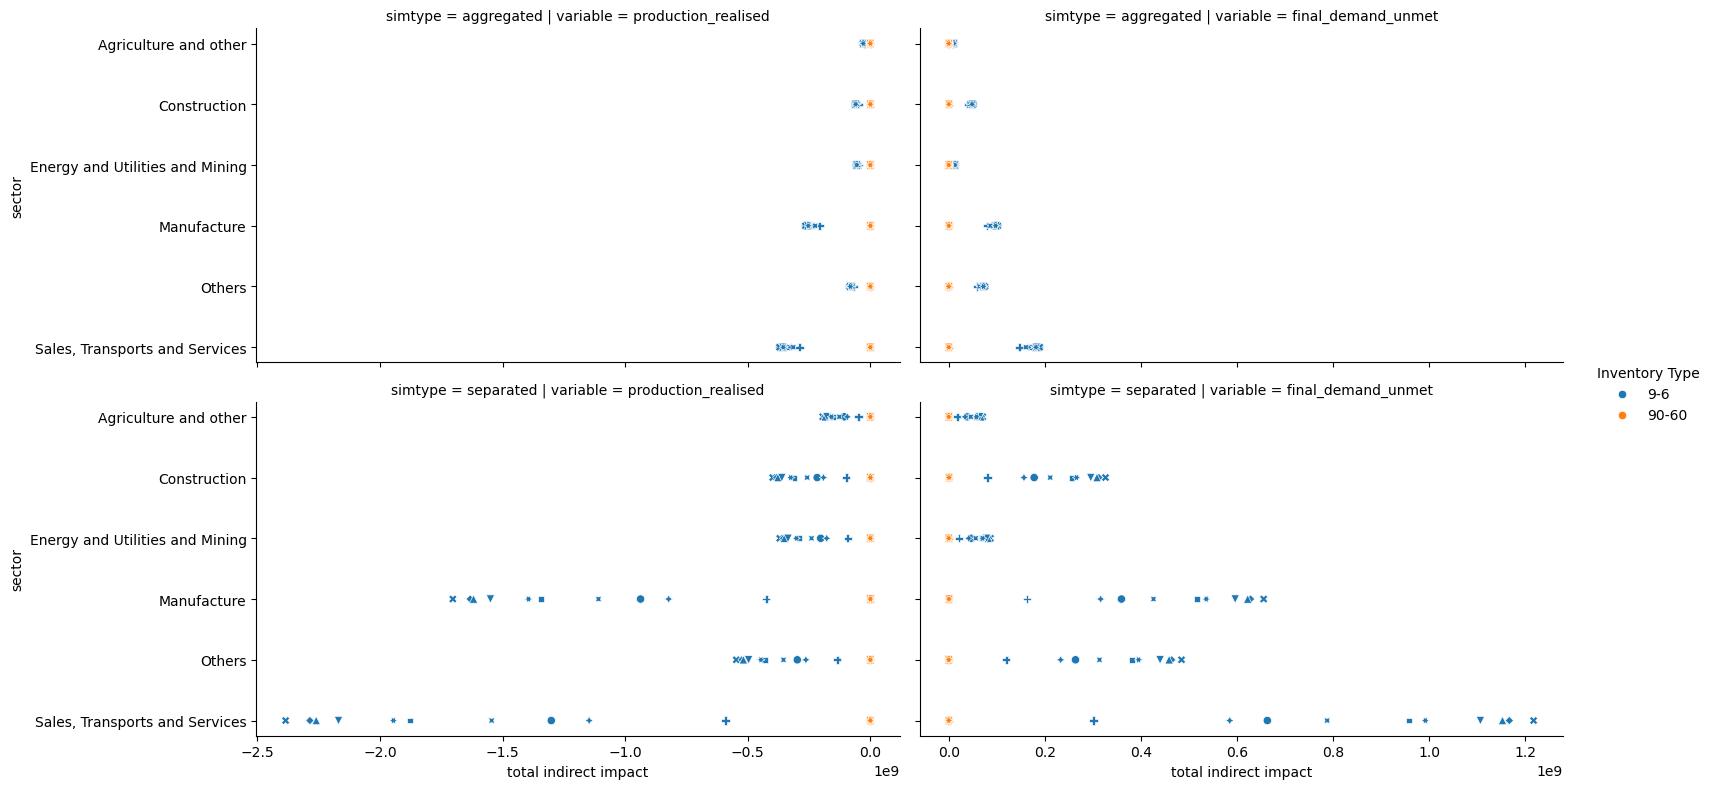

In [36]:
# Set up the grid layout
g = sns.FacetGrid(res_df, col="variable", row="simtype", hue="invtype", height=4, aspect=2, sharex="col", col_order=["production_realised","final_demand_unmet"])

# Plot scatter plots
g.map_dataframe(sns.scatterplot,
                y="sector",
                x="total indirect impact",
                style="sample")

# Add legend
g.add_legend(title="Inventory Type")

# Adjust layout
g.tight_layout()

# Show the plot
plt.show()

<AxesSubplot: xlabel='0'>

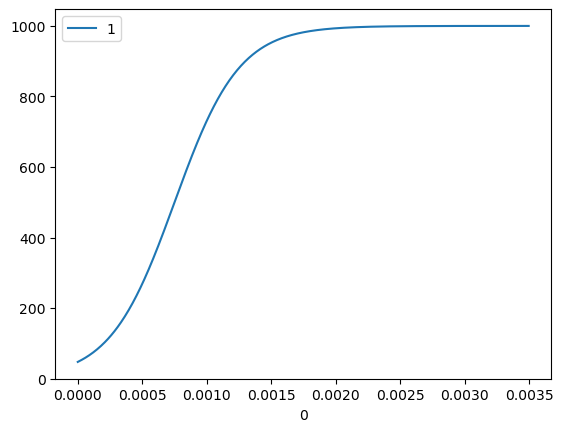

In [38]:
import math
def sigmoid_mapping(value, slope, midpoint,
                    start_in_intrvl=0, end_in_intrvl=0.005,
                    start_out_intrvl=-5, end_out_intrvl=5, max_duration=1000):
    # Map the input value from [0, 0.005] to [-5, 5]
    normalized_value = (value) / (end_in_intrvl - start_in_intrvl) * (end_out_intrvl - start_out_intrvl) - end_out_intrvl
    
    # Apply sigmoid function with adjustable slope and midpoint
    shifted_value = normalized_value - midpoint
    sigmoid_result = 1 / (1 + math.exp(-slope * shifted_value))
    
    # Scale the result to [0, 1500]
    scaled_result = sigmoid_result * max_duration
    
    return scaled_result

s = pd.Series(np.arange(0.,0.003497,0.000005))
df = pd.concat([s,s.apply(lambda x : sigmoid_mapping(x,slope=2, midpoint=-3.5))],axis=1)
df.plot(x=0,y=1)

In [68]:
with open("../../Boario-Climada-Compound_Events/outputs/EXIOBASE3-2010_supchain.pkl","rb") as f:
    supchain = pkl.load(f)

def map_to_logarithmic_curve(value, min_input, max_input, min_output, max_output):
    normalized_value = (value - min_input) / (max_input - min_input)
    logarithmic_value = math.log(normalized_value * 999 + 1, 1000)  # Adjust the base for desired curve
    mapped_value = min_output + logarithmic_value * (max_output - min_output)
    return mapped_value

def sigmoid_mapping(input_value, slope, midpoint):
    # Map the input value from [0, 0.005] to [-5, 5]
    normalized_value = (input_value / 0.005) * 10 - 5
    
    # Apply sigmoid function with adjustable slope and midpoint
    shifted_value = normalized_value - midpoint
    sigmoid_result = 1 / (1 + math.exp(-slope * shifted_value))
    
    # Scale the result to [0, 1500]
    scaled_result = sigmoid_result * 1000
    
    return scaled_result


meta_df = df.sum(axis=1).to_frame("total_damage").rename_axis("step")#.reset_index()
meta_df["affected"] = df.apply(lambda row:row[row>0].index.get_level_values(0).unique().to_list(), axis=1)
tmp = (df / supchain.secs_exp.iloc[0]).groupby("region",axis=1).min().stack()
meta_df["max_shock_intensity"] = tmp.loc[tmp!=0].groupby(level=0).max()
meta_df["max_shock_intensity_pct"] = tmp.loc[tmp!=0].groupby(level=0).max()*100
meta_df["recovery_duration"] = meta_df["max_shock_intensity"].apply(lambda x : sigmoid_mapping(x,slope=2, midpoint=-3.5)).round().astype(int)
meta_df

,total_damage,affected,max_shock_intensity,max_shock_intensity_pct,recovery_duration
step,,,,,
40.0,2.647358e+08,"[CN, JP]",0.000006,0.000635,49
56.0,2.847758e+08,[ROW],0.000011,0.001119,49
48.0,6.039026e+08,[JP],0.000032,0.003194,54
62.0,4.785506e+09,"[CN, ROW]",0.000115,0.011457,73
0.0,1.122095e+09,[ROW],0.000044,0.004407,56
472.0,5.966202e+08,"[JP, KR]",0.000030,0.003048,53
426.0,4.630074e+09,"[CN, TW]",0.002744,0.274353,1000
378.0,3.184148e+08,[JP],0.000017,0.001684,51
821.0,2.754127e+09,[JP],0.000146,0.014568,82


<Axes: xlabel='max_shock_intensity_pct', ylabel='recovery_duration'>

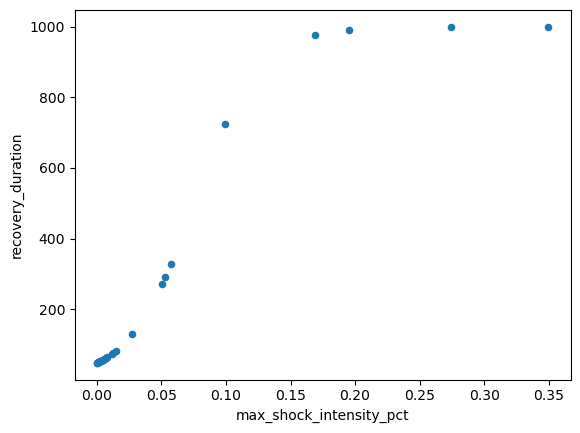

In [69]:
meta_df.plot(x="max_shock_intensity_pct", y="recovery_duration", kind="scatter")

In [128]:
meta_df.iloc[2]["recovery_duration"]

105.97154389616097

In [ ]:
def shock_economy_share(df_impact, df_assets):
    return df_impact.apply(lambda row: (row / df_assets), axis=1)

#(df.loc[0].sum() / supchain.secs_exp.loc[:,(df.loc[0]!=0)].sum().sum())
#shock_economy_share(df, supchain.secs_exp)
#df
_df = (df / supchain.secs_exp.iloc[0]).groupby("region",axis=1).min().stack()
_df.loc[_df!=0].groupby(level=0).mean()#.sort_values() * 1 

In [134]:
#for ev in df.iterrows():
#    print(ev[0])
meta_df.loc[40,"recovery_duration"]

93.17500102140134

In [142]:
import numpy as np
df_sorted = df.sort_index()

def accumulate_values(start, to_add):
    result = np.array(np.cumsum([start] + to_add))
    result = np.insert(result, 0, start)
    return result

def halve_index_gap(df):
    halved_gaps = (np.diff(df.index)/2).round().astype(int)
    new_index = accumulate_values(df_sorted.index[0], halved_gaps)
    df_reindexed = df.copy()
    df_reindexed.index = new_index
    return df_reindexed

# Reindex the dataframe with halved index gap
df_halved = halve_index_gap(df_sorted)
df_halved = halve_index_gap(df_halved)
#df_halved = halve_index_gap(df_halved)
#df_halved = halve_index_gap(df_halved)
#df_halved = halve_index_gap(df_halved)
#df_halved = halve_index_gap(df_halved)

# Print the reindexed dataframe

df_sorted

region                             AT                      
sector Sales, Transports and Services Others Manufacture   
0.0                               0.0    0.0         0.0  \
34.0                              0.0    0.0         0.0   
40.0                              0.0    0.0         0.0   
48.0                              0.0    0.0         0.0   
56.0                              0.0    0.0         0.0   
62.0                              0.0    0.0         0.0   
66.0                              0.0    0.0         0.0   
87.0                              0.0    0.0         0.0   
378.0                             0.0    0.0         0.0   
416.0                             0.0    0.0         0.0   
426.0                             0.0    0.0         0.0   
472.0                             0.0    0.0         0.0   
787.0                             0.0    0.0         0.0   
794.0                             0.0    0.0         0.0   
800.0                             0.0    0.0         0.0   
811.0                             0.0    0.0         0.0   
813.0                             0.0    0.0         0.0   
815.0                             0.0    0.0         0.0   
821.0                             0.0    0.0         0.0   
1077.0                            0.0    0.0         0.0   
1106.0                            0.0    0.0         0.0   
1159.0                            0.0    0.0         0.0   
1162.0                            0.0    0.0         0.0   
1185.0                            0.0    0.0         0.0   
1462.0                            0.0    0.0         0.0   
1518.0                            0.0    0.0         0.0   
1531.0                            0.0    0.0         0.0   
1544.0                            0.0    0.0         0.0   
1548.0                            0.0    0.0         0.0   
1555.0                            0.0    0.0         0.0   

region                                                                      
sector Agriculture and other Energy and Utilities and Mining Construction   
0.0                      0.0                             0.0          0.0  \
34.0                     0.0                             0.0          0.0   
40.0                     0.0                             0.0          0.0   
48.0                     0.0                             0.0          0.0   
56.0                     0.0                             0.0          0.0   
62.0                     0.0                             0.0          0.0   
66.0                     0.0                             0.0          0.0   
87.0                     0.0                             0.0          0.0   
378.0                    0.0                             0.0          0.0   
416.0                    0.0                             0.0          0.0   
426.0                    0.0                             0.0          0.0   
472.0                    0.0                             0.0          0.0   
787.0                    0.0                             0.0          0.0   
794.0                    0.0                             0.0          0.0   
800.0                    0.0                             0.0          0.0   
811.0                    0.0                             0.0          0.0   
813.0                    0.0                             0.0          0.0   
815.0                    0.0                             0.0          0.0   
821.0                    0.0                             0.0          0.0   
1077.0                   0.0                             0.0          0.0   
1106.0                   0.0                             0.0          0.0   
1159.0                   0.0                             0.0          0.0   
1162.0                   0.0                             0.0          0.0   
1185.0                   0.0                             0.0          0.0   
1462.0                   0.0                             0.0          0.0   


In [88]:
df_sum_1=df.sum(axis=0).to_frame(name="total direct damage")
df_sum_1["sample"] = 0
df_sum_1["MRIOT"] = "Exio"
df_sum_1.reset_index(inplace=True)
df_sum_1.set_index(["sample","MRIOT","region","sector"], inplace=True)
df_sum_1

total direct damage
sample MRIOT region sector                                              
0      Exio  AT     Sales, Transports and Services                   0.0
                    Others                                           0.0
                    Manufacture                                      0.0
                    Agriculture and other                            0.0
                    Energy and Utilities and Mining                  0.0
...                                                                  ...
             ZA     Others                                           0.0
                    Manufacture                                      0.0
                    Agriculture and other                            0.0
                    Energy and Utilities and Mining                  0.0
                    Construction                                     0.0

[270 rows x 1 columns]

In [92]:
df_sum = (agg-agg.loc[0]).sum(axis=0).to_frame("total indirect impact")
df_sum["sample"] = 0
df_sum["MRIOT"] = "Exio"
df_sum["simtype"]= "agg"
df_sum["variable"] = "prod"
df_sum.reset_index(inplace=True)
df_sum.set_index(["sample","MRIOT","region","sector"], inplace=True)

df_sum_2 = (agg-agg.loc[0]).sum(axis=0).to_frame("total indirect impact")
df_sum_2["sample"] = 0
df_sum_2["MRIOT"] = "Exio"
df_sum_2["simtype"]= "sep"
df_sum_2["variable"] = "prod"
df_sum_2.reset_index(inplace=True)
df_sum_2.set_index(["sample","MRIOT","region","sector"], inplace=True)

df_sum = pd.concat([df_sum,df_sum_2])

In [93]:
df_sum

total indirect impact  \
sample MRIOT region sector                                                   
0      Exio  AT     Agriculture and other                        -1.921141   
                    Construction                                484.044500   
                    Energy and Utilities and Mining               1.772278   
                    Manufacture                                 167.413361   
                    Others                                       -7.101753   
...                                                                    ...   
             ZA     Construction                                 63.381583   
                    Energy and Utilities and Mining             -31.836737   
                    Manufacture                                 215.752869   
                    Others                                      -12.578094   
                    Sales, Transports and Services             -244.506148   

                                                    simtype variable  
sample MRIOT region sector                                            
0      Exio  AT     Agriculture and other               agg     prod  
                    Construction                        agg     prod  
                    Energy and Utilities and Mining     agg     prod  
                    Manufacture                         agg     prod  
                    Others                              agg     prod  
...                                                     ...      ...  
             ZA     Construction                        sep     prod  
                    Energy and Utilities and Mining     sep     prod  
                    Manufacture                         sep     prod  
                    Others                              sep     prod  
                    Sales, Transports and Services      sep     prod  

[540 rows x 3 columns]

In [94]:
df_sum_1.join(df_sum)

total direct damage  \
sample MRIOT region sector                                                 
0      Exio  AT     Agriculture and other                            0.0   
                    Agriculture and other                            0.0   
                    Construction                                     0.0   
                    Construction                                     0.0   
                    Energy and Utilities and Mining                  0.0   
...                                                                  ...   
             ZA     Manufacture                                      0.0   
                    Others                                           0.0   
                    Others                                           0.0   
                    Sales, Transports and Services                   0.0   
                    Sales, Transports and Services                   0.0   

                                                     total indirect impact  \
sample MRIOT region sector                                                   
0      Exio  AT     Agriculture and other                        -1.921141   
                    Agriculture and other                        -1.921141   
                    Construction                                484.044500   
                    Construction                                484.044500   
                    Energy and Utilities and Mining               1.772278   
...                                                                    ...   
             ZA     Manufacture                                 215.752869   
                    Others                                      -12.578094   
                    Others                                      -12.578094   
                    Sales, Transports and Services             -244.506148   
                    Sales, Transports and Services             -244.506148   

                                                    simtype variable  
sample MRIOT region sector                                            
0      Exio  AT     Agriculture and other               agg     prod  
                    Agriculture and other               sep     prod  
                    Construction                        agg     prod  
                    Construction                        sep     prod  
                    Energy and Utilities and Mining     agg     prod  
...                                                     ...      ...  
             ZA     Manufacture                         sep     prod  
                    Others                              agg     prod  
                    Others                              sep     prod  
                    Sales, Transports and Services      agg     prod  
                    Sales, Transports and Services      sep     prod  

[540 rows x 4 columns]